In [75]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

def read_folder(folder):
    results_full = [x for x in os.listdir(folder) if "metrics" in x][0]
    results_full = os.path.join(folder, results_full)
    with open(results_full, 'r') as f:
        results_full = json.load(f)
    return results_full

FPRATES = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

In [76]:
def plot_gradation(index, value_pretrained, values_non_pretrained, full, plot_non_pretrained_mean_only=False, plot_lr=False):
    # (keys, split_values) --> (keys,)
    pretrained_mean = np.array(value_pretrained).mean(axis=1)
    pretrained_std = np.array(value_pretrained).std(axis=1)
    non_pretrained_mean = np.array(values_non_pretrained).mean(axis=1)
    non_pretrained_std = np.array(values_non_pretrained).std(axis=1)
    full_mean = np.array(full).mean()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(index, pretrained_mean, yerr=pretrained_std, label="Pretrained", capsize=3)
    ax.scatter(index, pretrained_mean)
    if plot_non_pretrained_mean_only:
        ax.plot(index, np.array(values_non_pretrained).mean()*np.ones(len(index)), label="Non-pretrained", linestyle="--")
    else:
        ax.errorbar(index, non_pretrained_mean, yerr=non_pretrained_std, label="Non-pretrained", capsize=3)
        ax.scatter(index, non_pretrained_mean)
    ax.plot(index, full_mean*np.ones(len(index)), label="Full data", linestyle="--")
    # plot logirstic regression slope trained on pretrained_mean
    if plot_lr:
        # fit linear regression line for auc_mean
        from sklearn.linear_model import LinearRegression
        X = np.array(index).reshape(-1, 1)
        y = pretrained_mean
        model = LinearRegression().fit(X, y)
        # plot dashed red line of linear regression
        ax.plot(index, model.predict(X), color='red', linestyle='dashed', label="LR approximation")

    ax.grid()
    ax.legend()
    return ax

## variable unlabeled/labeled size ratio

In [77]:
result_folder = "uSize_loop"
folders = [os.path.join(result_folder, x) for x in os.listdir(result_folder) if "uSize" in x and ("log" not in x) and ("BROKEN" not in x)]
results = {}
for folder in folders:
    size = folder.split("_")[-2]
    results[size] = read_folder(folder)
results = {k:results[k] for k in sorted(results.keys())}
print(results.keys())

dict_keys(['0.7', '0.75', '0.8', '0.85', '0.9', '0.95', '0.97'])


Text(0.5, 0, 'unlabeled data size')

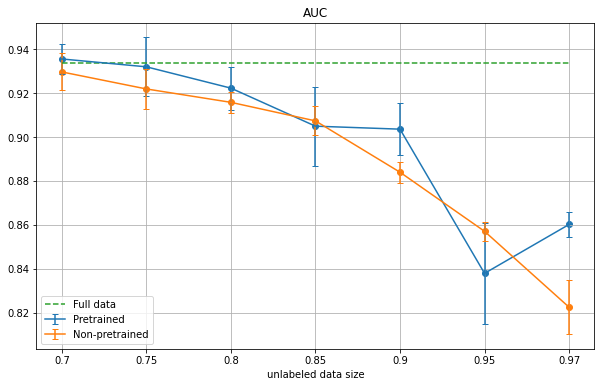

In [78]:
auc_full = np.array([results[x]['full_data']['auc'] for x in results.keys()])

value_pretrained = [results[x]['pretrained']['auc'] for x in results]
values_non_pretrained = [results[x]['non_pretrained']['auc'] for x in results]

ax = plot_gradation(results.keys(), value_pretrained, values_non_pretrained, auc_full)
ax.set_title("AUC")
ax.set_xlabel("unlabeled data size")

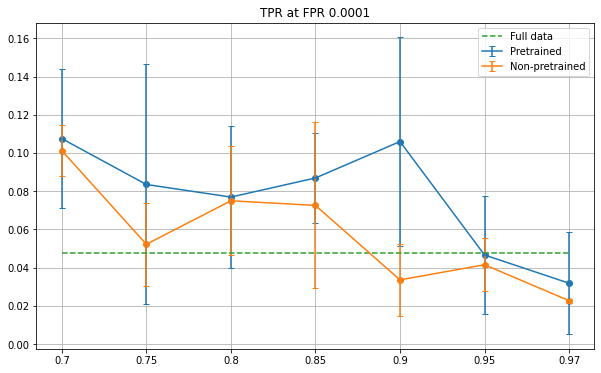

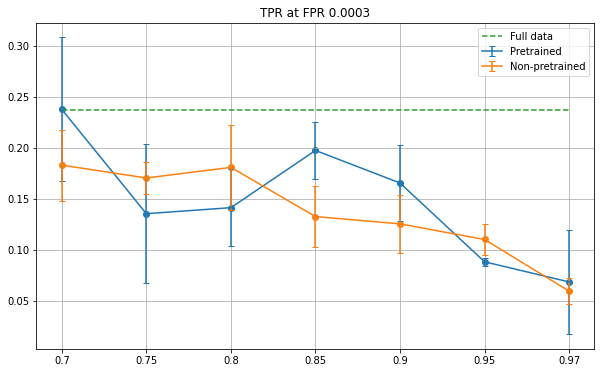

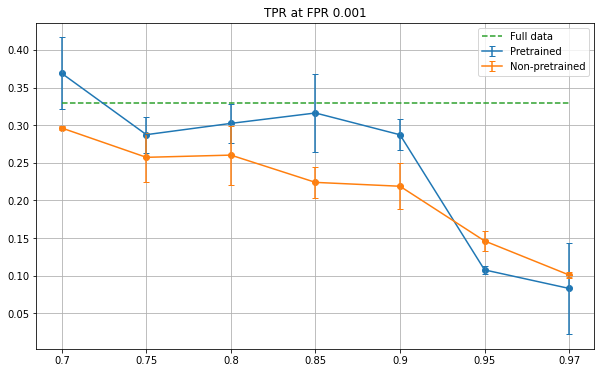

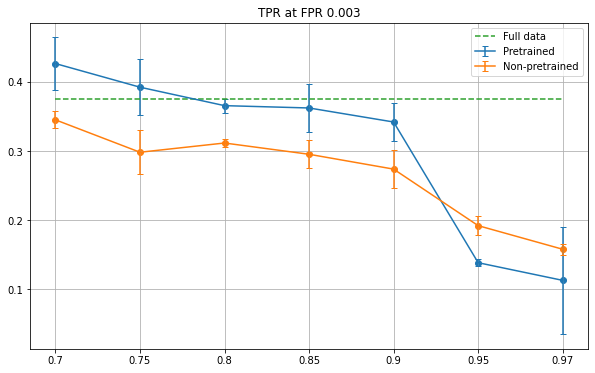

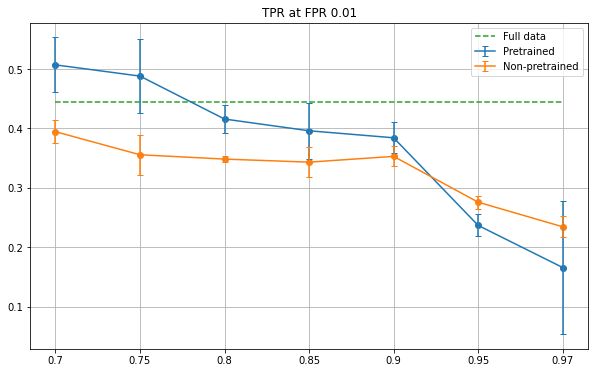

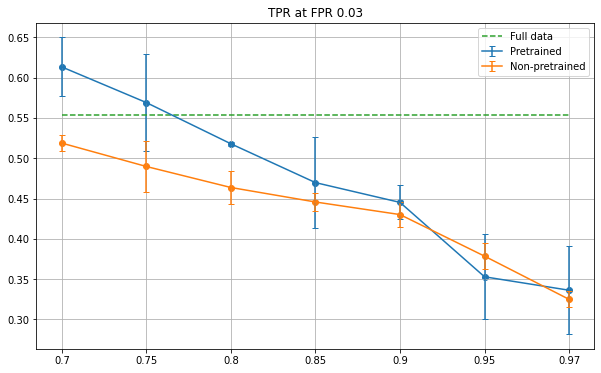

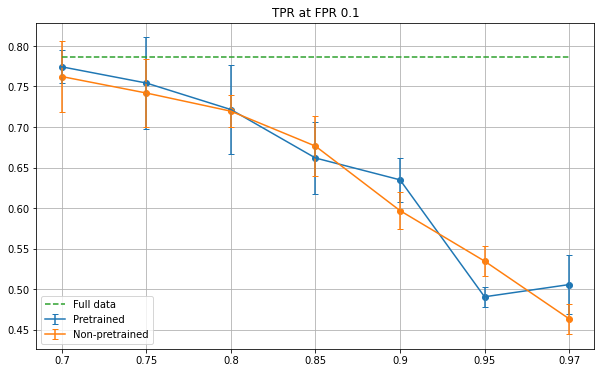

In [79]:
full = {}
for fpr in FPRATES:
    pr = [results[x]['pretrained'][f'fpr_{fpr}']['tpr'] for x in results]
    nonpr = [results[x]['non_pretrained'][f'fpr_{fpr}']['tpr'] for x in results]
    full[fpr] = [results[x]['full_data'][f'fpr_{fpr}']['tpr'] for x in results]
    ax = plot_gradation(results.keys(), pr, nonpr, full[fpr])
    ax.set_title(f"TPR at FPR {fpr}")

## variable unlabeled size / fixed labeled size (10% total size)

In [82]:
result_folder = "downsample_tests"
folders = [os.path.join(result_folder, x) for x in os.listdir(result_folder) if "downsample" in x and ("log" not in x) and ("BROKEN" not in x)]
results = {}
for folder in folders:
    size = folder.split("_")[3]
    try:
        results[size] = read_folder(folder)
    except IndexError:
        continue
results = {k:results[k] for k in sorted(results.keys())}
index = list([float(x) for x in results.keys()])
print(index)

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


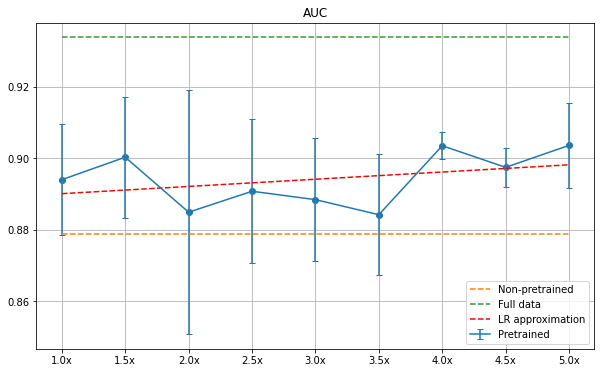

In [93]:
value_pretrained = [results[x]['pretrained']['auc'] for x in results]
values_non_pretrained = [results[x]['non_pretrained']['auc'] for x in results]

ax = plot_gradation(index, value_pretrained, values_non_pretrained, auc_full, plot_non_pretrained_mean_only=True, plot_lr=True)
_ = ax.set_title("AUC")
new_xticklabels = [f"{round(x/0.2,2)}x" for x in index]
_ = ax.set_xticklabels([""] + new_xticklabels)

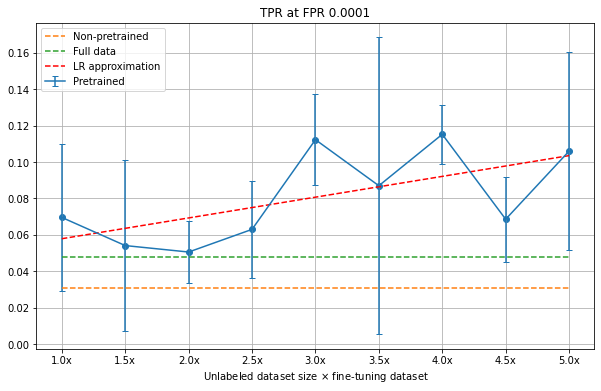

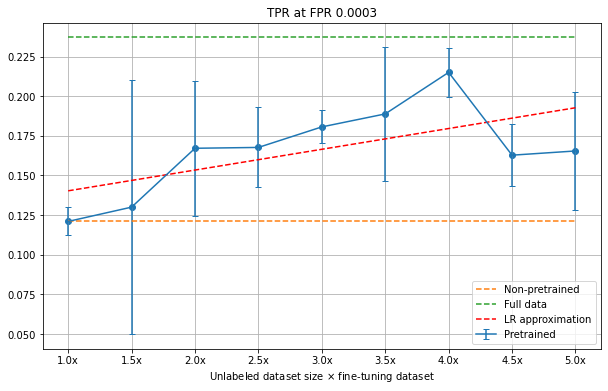

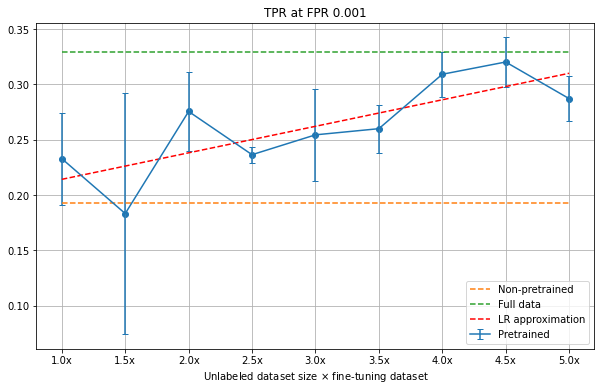

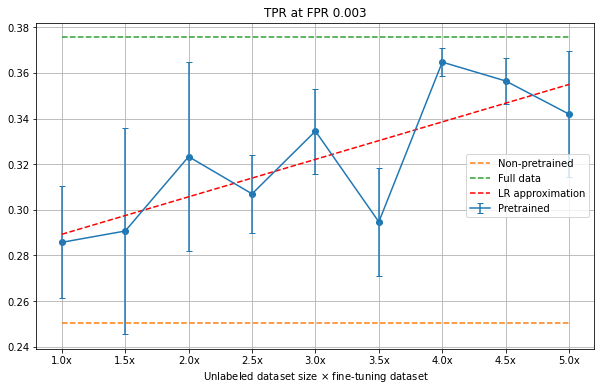

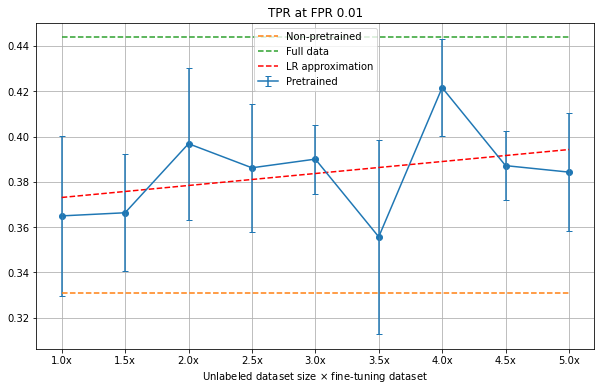

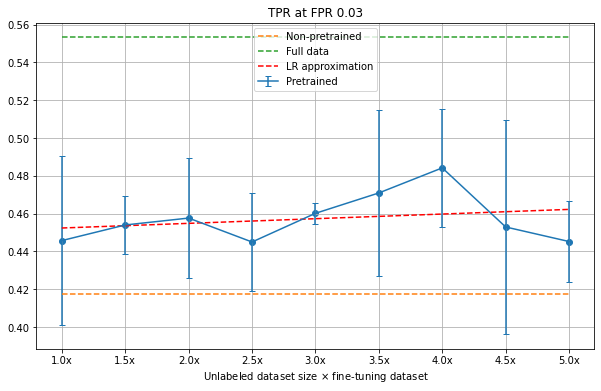

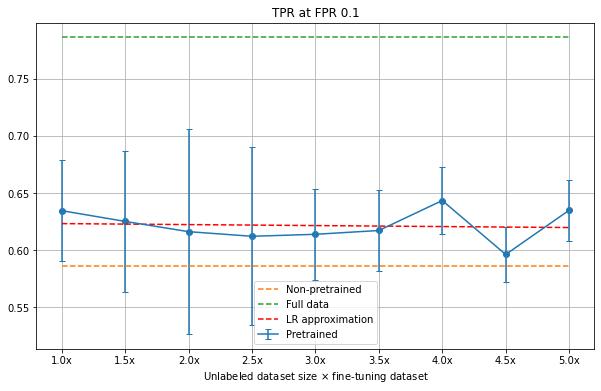

In [95]:
# supress UserWarning 
import warnings
warnings.filterwarnings('ignore')

for fpr in FPRATES:
    pr = [results[x]['pretrained'][f'fpr_{fpr}']['tpr'] for x in results]
    nonpr = [results[x]['non_pretrained'][f'fpr_{fpr}']['tpr'] for x in results]
    ax = plot_gradation(index, pr, nonpr, full[fpr], plot_non_pretrained_mean_only=True, plot_lr=True)
    ax.set_title(f"TPR at FPR {fpr}")
    _ = ax.set_xticklabels([""]+ [f"{round(float(x)/0.2,2)}x" for x in results.keys()])
    ax.set_xlabel(r"Unlabeled dataset size $\times$ fine-tuning dataset")
    